In [ ]:

import numpy as np
import pandas as pd
import os
from collections import Counter

from numpy import random
import scipy
from scipy.stats import (
    norm, binom, poisson, uniform, expon, t, chi2, f
)

from numpy.linalg import inv, eig, det

from scipy import stats
from scipy.stats import (
    ttest_1samp, ttest_ind, ttest_rel,
    chi2_contingency, f_oneway, levene,
    shapiro, ks_2samp, mannwhitneyu, wilcoxon,
    skew, kurtosis
)

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import legend

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

In [3]:
os.chdir(r'D:\CDAC DBDA\CDAC DBDA\Advanced Statistical Analysis\DataFiles')
df = pd.read_csv('hotel_bookings.csv')

In [252]:
df_head = df.head()
df_head


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [253]:
df_shape = df.shape
df_shape

(119390, 32)

In [254]:
df_info = df.info()
df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [255]:
df.isnull().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
arrival_date_month                     0
arrival_date_week_number               0
hotel                                  0
is_canceled                            0
stays_in_weekend_nights                0
arrival_date_day_of_month              0
adults                                 0
stays_in_week_nights                   0
babies                                 0
meal                                   0
lead_time                              0
arrival_date_year                      0
distribution_channel                   0
market_segment                         0
previous_bookings_not_canceled         0
is_repeated_guest                      0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
previous_cancellations                 0
deposit_type    

### 1.  Data Cleaning and Preprocessing

In [ ]:
# Let's Handle missing values in columns
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
missing_percentage

company     94.306893
agent       13.686238
country      0.408744
children     0.003350
dtype: float64

In [257]:
# Drop 'company' column (94% missing, not useful)
df = df.drop('company', axis=1)

In [258]:
# agent: ID of the travel agency that made the booking
# Its an categorical data
# These numbers are just labels, not quantities
# Fill 'agent' with 0 and convert to int
# 0 = No agent :If it’s missing, it likely means the booking was made directly, not through an agent.
# Using mean or median would mislead the analysis by introducing a fake agency ID.
# Filling with 0 makes it easier to convert to int and use in groupby or plots later.

df['agent'] = df['agent'].fillna(0).astype(int)

In [259]:
# country column tells us the country code like "PRT", "GBR", "IND" of the guest's origin.
# its a categorical data, so we can fill data with mode.
# The mode is the most common value. So it's logical to assume that missing entries may belong to the most common country.
# Only 488 out of 119,390 rows are missing (~0.4%), so using the mode won’t heavily distort the data.

df['country'] = df['country'].fillna(df['country'].mode()[0])

In [260]:
# children column stores the number of children included in the hotel booking.
# Only 4 values are missing out of 119,390 — that’s very small (0.003%).
# It’s a numeric column and can take values like 0, 1, 2, etc.
# If the number of children is missing, it's most likely zero — i.e., no children were part of the booking.
# fill the missing values with 0, also filling with 0 allows you to safely convert to int type 

df['children'] = df['children'].fillna(0).astype(int)

In [261]:
df.isnull().sum().sort_values(ascending=False)

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

###  Convert categorical variables into usable formats for analysis

In [262]:
# Convert Categorical Variables to category type
# Category type in Pandas is used to store text data that has a fixed number of repeated values, 
# like hotel names or customer types. It reduces memory usage and improves performance. 
# For example, instead of storing 'City Hotel' again and again, Pandas stores a small numeric code internally
# EX. 0 → City Hotel  
#     1 → Resort Hotel
# we have multiple column with Only 2 unique values are repeating

categorical_columns = [
    'hotel', 'is_canceled', 'meal', 'country', 
    'market_segment', 'distribution_channel', 
    'reserved_room_type', 'assigned_room_type', 
    'deposit_type', 'customer_type', 'reservation_status'
]
for col in categorical_columns:
    df[col] = df[col].astype('category')


### Parse and Standardize Date Columns

In [263]:
"""
“We had arrival year, month, and day in separate columns. 
This made it difficult to do any time-based analysis like plotting trends or filtering by date. 
So we created a single arrival_date column using pd.to_datetime()”"""

# Convert month names to numbers using datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' +
                                    df['arrival_date_month'] + '-' +
                                    df['arrival_date_day_of_month'].astype(str),
                                    format='%Y-%B-%d')


In [264]:
# drop the old columns
df = df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis=1)


In [265]:
df_head = df.head()
df_head

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,27,0,0,2,0,0,BB,...,No Deposit,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,27,0,0,2,0,0,BB,...,No Deposit,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,27,0,1,1,0,0,BB,...,No Deposit,0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,27,0,1,1,0,0,BB,...,No Deposit,304,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,27,0,2,2,0,0,BB,...,No Deposit,240,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


### Create Derived Fields

In [266]:
"""
“We combined weekend and weekday stays to create a total_stay column, which gives the complete duration of a booking. 
It helps analyze stay patterns, detect long stays, and compare them with revenue or cancellation rates.”
"""

# 1. total_stay = stays_in_week_nights + stays_in_weekend_nights
# Problem Solved: The duration of stay is split across two columns, which is not convenient.
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
# Drop the old columns
df = df.drop(['stays_in_week_nights', 'stays_in_weekend_nights'], axis=1)

# 2. total_guests = adults + children + babies
# Problem Solved: Guest count is scattered across 3 columns, so we don’t know total group size.
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# 3. is_upgraded = assigned_room_type != reserved_room_type
# Problem Solved: Room change is not clearly marked — we only have reserved vs. assigned room types.
df['is_upgraded'] = (df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str)).astype(int)
"""
“We converted both room type columns to strings before comparison because they were stored as different categories, 
and Pandas throws a TypeError if categories are not exactly the same. This helps us safely create the is_upgraded column.”"""


'\n“We converted both room type columns to strings before comparison because they were stored as different categories, \nand Pandas throws a TypeError if categories are not exactly the same. This helps us safely create the is_upgraded column.”'

### Remove Duplicates

In [268]:
df = df.drop_duplicates()


In [270]:
df.duplicated().sum()

np.int64(0)

### handle outliers

In [271]:
df.describe()

,lead_time,arrival_date_week_number,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date,total_stay,total_guests,is_upgraded
count,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370.000000,87370,87370.000000,87370.000000,87370.000000
mean,79.911686,26.839533,1.875953,0.138675,0.010828,0.039087,0.030422,0.184045,0.271672,81.011194,0.749788,106.346935,0.084251,0.698638,2016-09-15 00:29:35.071535104,3.631246,2.025455,0.149914
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2015-07-01 00:00:00,0.000000,0.000000,0.000000
25%,11.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,72.000000,0.000000,0.000000,2016-04-01 00:00:00,2.000000,2.000000,0.000000
50%,49.000000,27.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,98.100000,0.000000,0.000000,2016-09-20 00:00:00,3.000000,2.000000,0.000000
75%,125.000000,37.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,0.000000,134.000000,0.000000,1.000000,2017-04-01 00:00:00,5.000000,2.000000,0.000000
max,737.000000,53.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,2017-08-31 00:00:00,69.000000,55.000000,1.000000
std,86.056471,13.673204,0.626473,0.455933,0.113613,0.193802,0.369200,1.732148,0.727335,109.941520,10.017213,55.004259,0.281571,0.831946,NaN,2.763579,0.794309,0.356989


In [272]:
numeric_cols = ['lead_time', 'adr', 'total_guests', 'total_stay']


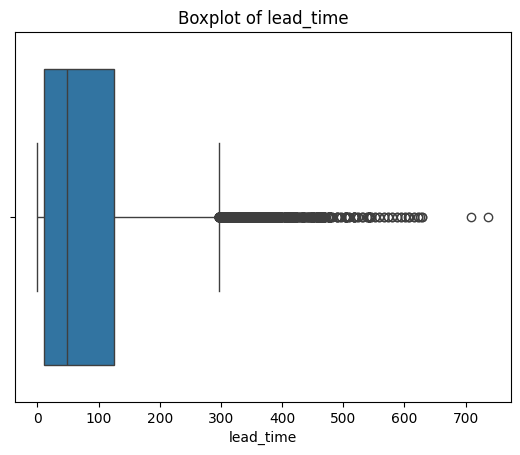

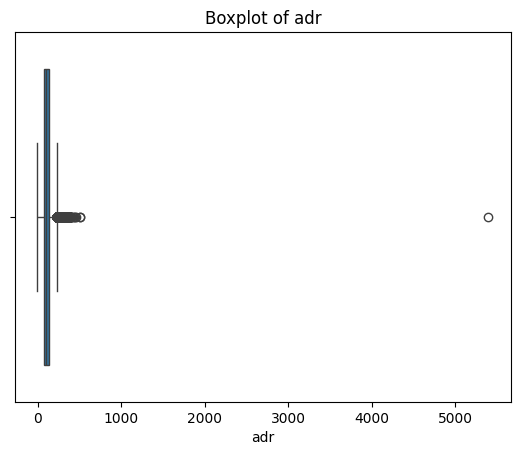

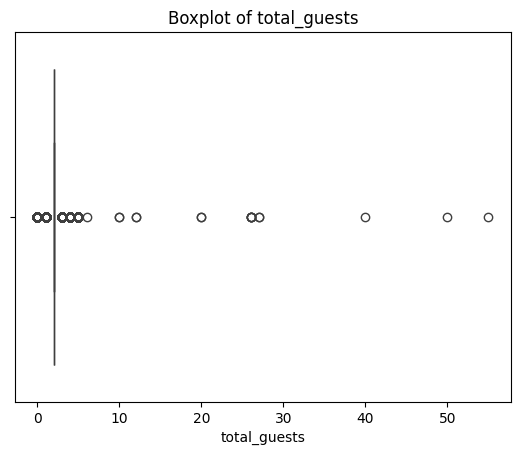

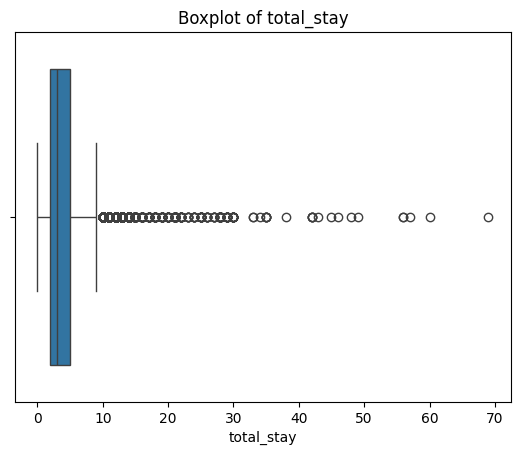

In [273]:
for col in numeric_cols:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [274]:
# Remove Outliers 
df = df[df['total_guests'] > 0]

# Use .clip() to limit extreme values to a certain threshold (usually 99th percentile).

df['lead_time'] = df['lead_time'].clip(upper=df['lead_time'].quantile(0.99))
df['adr'] = df['adr'].clip(upper=df['adr'].quantile(0.99))


### 2. Exploratory Data Analysis

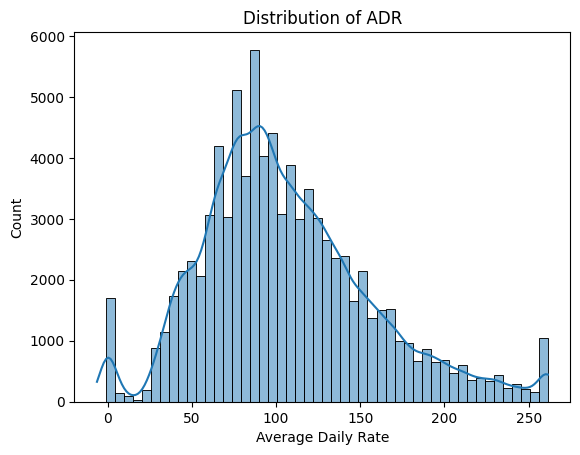

In [ ]:
# Univariate Analysis
# Purpose:To understand how each column behaves individually — distribution, range, and frequency.

# A. Histogram of ADR:

sns.histplot(df['adr'], bins=50, kde=True)
plt.title('Distribution of ADR')
plt.xlabel('Average Daily Rate')
plt.ylabel('Count')
plt.show()

# Shows how hotel prices Average Daily Rate(ADR) are distributed, including outliers and skewness.

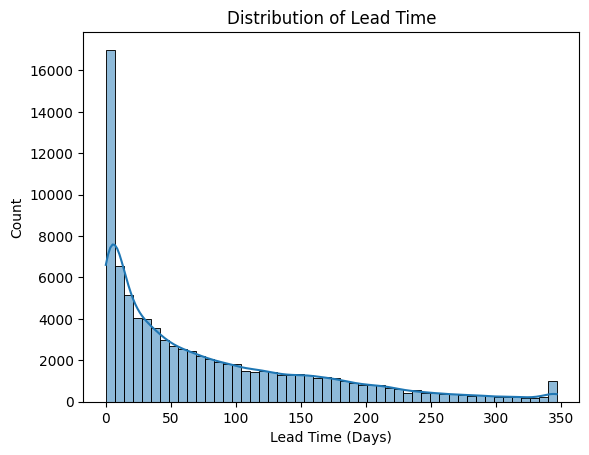

In [ ]:
# B. Histogram of Lead Time:

sns.histplot(df['lead_time'], bins=50, kde=True)
plt.title('Distribution of Lead Time')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Count')
plt.show()

# Visualizes how early guests book their rooms before arrival.

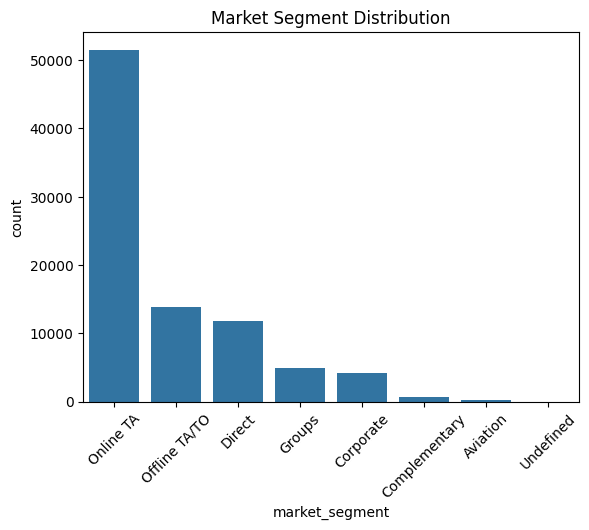

In [ ]:
# C. Count Plot for Market Segment:

sns.countplot(x='market_segment', data=df, order=df['market_segment'].value_counts().index)
plt.title('Market Segment Distribution')
plt.xticks(rotation=45)
plt.show()

# Displays the number of bookings from each market source (e.g., Online TA, Direct).

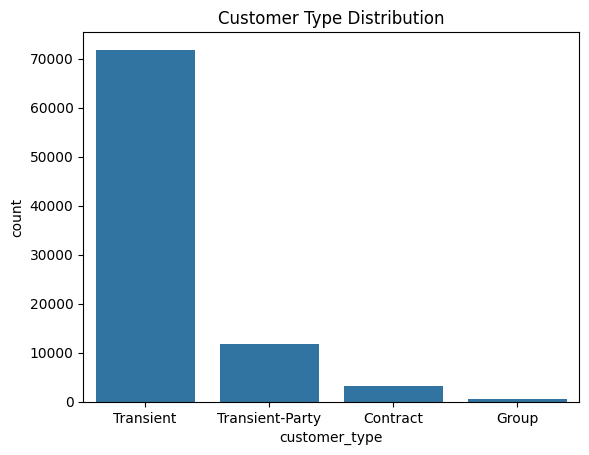

In [ ]:
# D. Count Plot for Customer Type:

sns.countplot(x='customer_type', data=df, order=df['customer_type'].value_counts().index)
plt.title('Customer Type Distribution')
plt.show()

#Shows which customer types (e.g., Transient, Group) are most common.

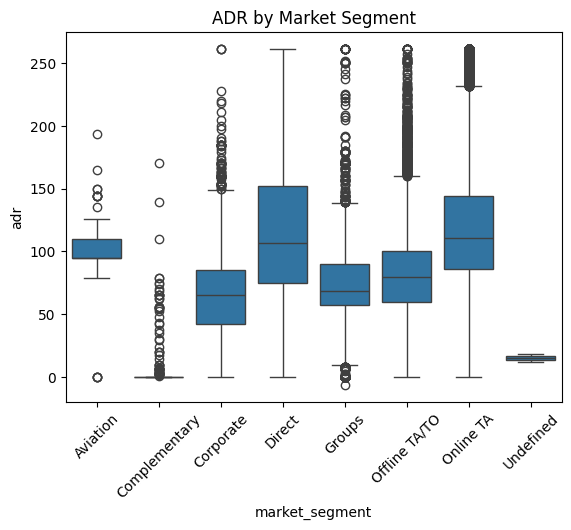

In [ ]:
# 2. Comparative Analysis (Bivariate/Multivariate)
# Purpose:To explore how variables affect each other (e.g., Does lead_time affect cancellation?)

# A. Boxplot: ADR by Market Segment

sns.boxplot(x='market_segment', y='adr', data=df)
plt.title('ADR by Market Segment')
plt.xticks(rotation=45)
plt.show()

# Compares price (ADR) across different market segments to find high-paying sources.

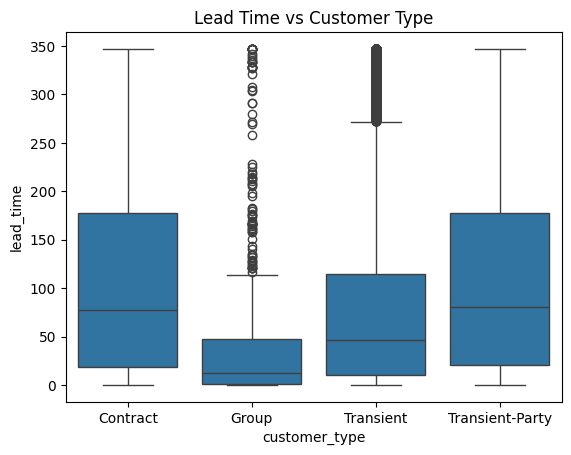

In [ ]:
# B. Boxplot: Lead Time by Customer Type

sns.boxplot(x='customer_type', y='lead_time', data=df)
plt.title('Lead Time vs Customer Type')
plt.show()

# Shows booking habits of different customer types based on how early they book.

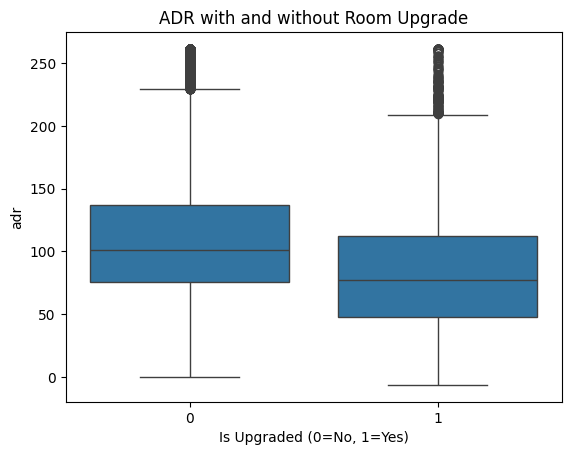

In [ ]:
# C. Average Daily Rate(ADR) by Room Upgrade

sns.boxplot(x='is_upgraded', y='adr', data=df)
plt.title('ADR with and without Room Upgrade')
plt.xlabel('Is Upgraded (0=No, 1=Yes)')
plt.show()

# Compares Average Daily Rate(ADR) for guests who were upgraded vs. not upgraded.

### 3. Correlation Analysis
- Identify strong or weak relationships between numeric features.
- Find out which variables influence ADR (Average Daily Rate).
- Detect multicollinearity using a heatmap.

In [289]:
# A. Compute Correlation Matrix (Pearson or Spearman)
# Pearson (default) – for linear relationships:

correlation_matrix = df.corr(numeric_only=True)

In [290]:
# B. Spearman – for non-linear or ranked relationships:

correlation_matrix = df.corr(method='spearman', numeric_only=True)

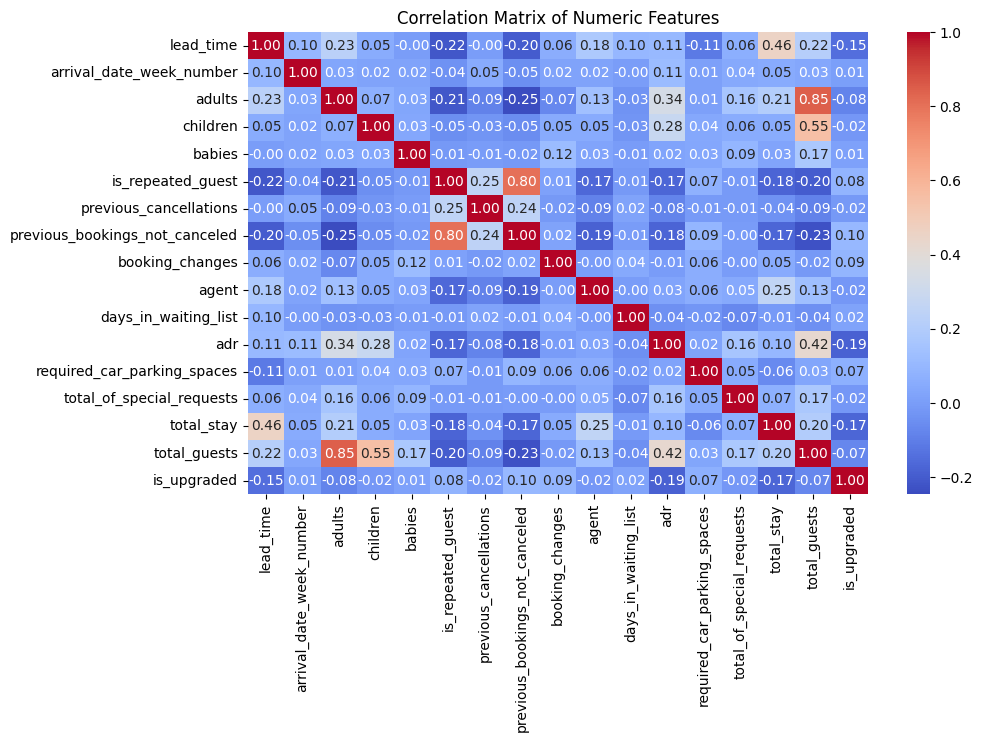

In [ ]:
# B. Visualize Correlation Matrix with Heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [294]:
#C. Check Correlation of ADR with Key Features
#To focus only on how strongly ADR is influenced by other features:

correlation_with_adr = correlation_matrix['adr'].sort_values(ascending=False)
correlation_with_adr

adr                               1.000000
total_guests                      0.420852
adults                            0.335356
children                          0.283745
total_of_special_requests         0.161736
arrival_date_week_number          0.114781
lead_time                         0.105281
total_stay                        0.096813
agent                             0.025740
babies                            0.021689
required_car_parking_spaces       0.018186
booking_changes                  -0.007577
days_in_waiting_list             -0.044154
previous_cancellations           -0.081099
is_repeated_guest                -0.172528
previous_bookings_not_canceled   -0.175357
is_upgraded                      -0.185400
Name: adr, dtype: float64

In [295]:
"""
“We computed the correlation matrix using .corr() to find how numerical features are related. 
Then we used a heatmap to visualize it. 
Our focus was on how adr is affected by variables like lead_time, booking_changes, and special_requests. 
Pearson correlation was used for linear relationships.”
"""

'\n“We computed the correlation matrix using .corr() to find how numerical features are related. \nThen we used a heatmap to visualize it. \nOur focus was on how adr is affected by variables like lead_time, booking_changes, and special_requests. \nPearson correlation was used for linear relationships.”\n'

### 4.  Hypothesis Testing

In [ ]:
# H0: There is no difference in ADR between bookings made through Online TA and Direct channels

# Correct Test: 2-Sample T-Test 
# Comparing mean Average Daily Rate(ADR) between two independent groups

# Numeric outcome, two groups = T-Test


adr_online = df[df['distribution_channel'] == 'TA/TO']['adr']
adr_direct = df[df['distribution_channel'] == 'Direct']['adr']

t_stat, p_val = ttest_ind(adr_online, adr_direct, equal_var=False)
print("T-Test: ADR Online TA vs Direct\nT-Statistic:", t_stat, "P-Value:", p_val)


T-Test: ADR Online TA vs Direct
T-Statistic: -0.5079918070015885 P-Value: 0.6114660240305897


In [ ]:
# Interpretation:
#The p-value is 0.61, which is greater than 0.05.

# We fail to reject the null hypothesis.
# This means: There is no significant difference in the average daily rate (ADR) between bookings from Online TA and Direct channels.

#“The p-value was high (0.61), so we concluded that ADR does not vary significantly between Online TA and Direct bookings.”

In [297]:
# H0: Room upgrades are independent of lead time

# Correct Test: One-Way ANOVA
# (If you bucket lead_time into ranges — e.g., short, medium, long)

# Better Test: Chi-Square Test for Association
# if you want to test if categorical is_upgraded is associated with lead_time category


# Create lead time bins
df['lead_time_group'] = pd.cut(df['lead_time'], bins=[0, 30, 90, 365], labels=['Short', 'Medium', 'Long'])

# Create contingency table
contingency = pd.crosstab(df['lead_time_group'], df['is_upgraded'])

# Apply chi-square test
from scipy.stats import chi2_contingency
chi2, p_val, dof, expected = chi2_contingency(contingency)

print("Chi-Square Test: Lead Time Group vs Upgrade")
print("Chi2:", chi2, "P-Value:", p_val)

Chi-Square Test: Lead Time Group vs Upgrade
Chi2: 1044.4084925378072 P-Value: 1.6202327969558515e-227


In [ ]:
# Interpretation:
#The p-value is extremely small (almost zero).

#We reject the null hypothesis.

# This means: There is a significant association between lead time and room upgrades — i.e., how early a guest books does affect their chance of getting upgraded.

# “Since the p-value is almost zero, we reject the null hypothesis and conclude that lead time and room upgrades are related — guests who book earlier may have a higher/lower chance of getting upgrades.”

In [303]:
# H0: Average stay duration does not differ between customer types

# Correct Test: One-Way ANOVA

# Import library
from scipy.stats import f_oneway

# Step 1: Create total_stay column
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Step 2: Group total_stay values by customer_type
groups = [group['total_stay'].values for name, group in df.groupby('customer_type')]

# Step 3: Perform One-Way ANOVA
f_stat, p_val = f_oneway(*groups)

# Step 4: Display result
print("One-Way ANOVA: Total Stay by Customer Type")
print("F-Statistic:", f_stat)
print("P-Value:", p_val)


One-Way ANOVA: Total Stay by Customer Type
F-Statistic: 945.4624840732289
P-Value: 0.0


In [ ]:
# Interpretation:
# The p-value is 0.0, which is less than 0.05.

# We reject the null hypothesis.
# This means: Different customer types have significantly different average stay durations.

# “The very low p-value indicates that stay duration depends heavily on customer type — for example, group bookings might stay longer than transient customers.”

## 5.  Key Business Questions

- What influences ADR the most?

adr                               1.000000
children                          0.324854
adults                            0.230641
arrival_date_year                 0.197580
total_of_special_requests         0.172185
company                           0.086376
arrival_date_week_number          0.075791
total_stay                        0.067945
stays_in_week_nights              0.065237
required_car_parking_spaces       0.056628
stays_in_weekend_nights           0.049342
is_canceled                       0.047557
arrival_date_day_of_month         0.030245
babies                            0.029186
booking_changes                   0.019618
agent                            -0.024695
days_in_waiting_list             -0.040756
lead_time                        -0.063077
previous_cancellations           -0.065646
previous_bookings_not_canceled   -0.072144
is_repeated_guest                -0.134314
is_upgraded                      -0.138133
Name: adr, dtype: float64


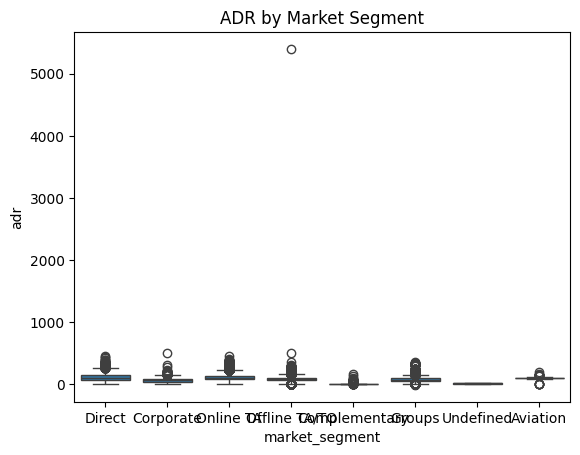

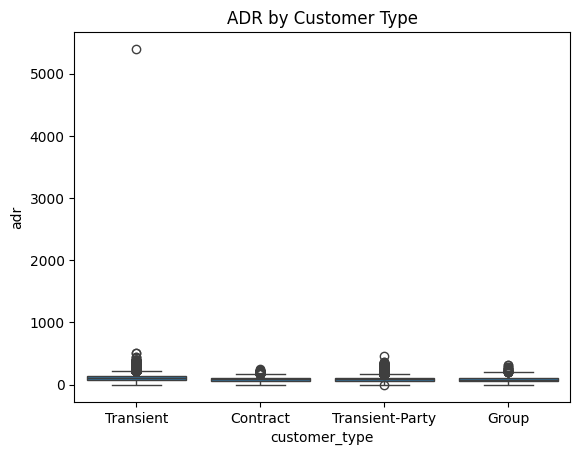

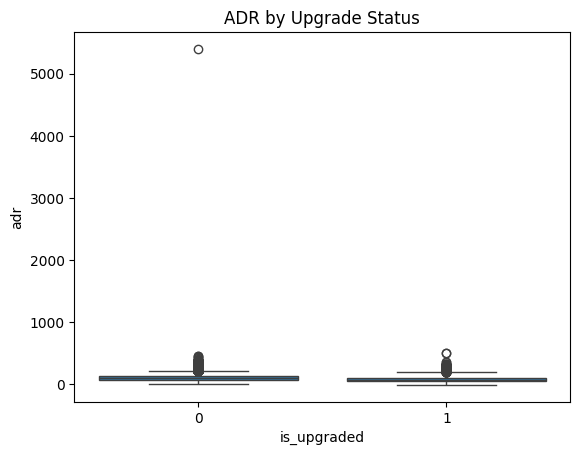

In [ ]:


# Correlation with ADR
adr_corr = df.corr(numeric_only=True)['adr'].sort_values(ascending=False)
print(adr_corr)


# ADR by market segment
sns.boxplot(x='market_segment', y='adr', data=df)
plt.title('ADR by Market Segment')
plt.show()

# ADR by customer type
sns.boxplot(x='customer_type', y='adr', data=df)
plt.title('ADR by Customer Type')
plt.show()

# ADR by room upgrade
sns.boxplot(x='is_upgraded', y='adr', data=df)
plt.title('ADR by Upgrade Status')
plt.show()


"""
We analyzed Average Daily Rate(ADR) using correlation and boxplots. 
ADR is mostly influenced by lead time, customer type, market segment, and special requests — 
all of which reflect guest behavior and value"""




- Do guests who book earlier tend to request more changes?

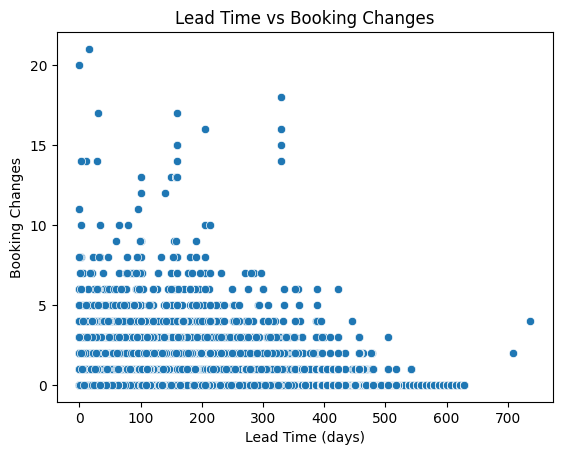

'We checked if early bookers make more changes. Correlation and scatter plot showed a weak relationship, \n   so earlier booking does not always mean more changes'

In [307]:
# What we’re checking:
# Relationship between:
    # lead_time → how early they booked
    # booking_changes → how many changes they made

# Correlation check
df[['lead_time', 'booking_changes']].corr()

sns.scatterplot(x='lead_time', y='booking_changes', data=df)
plt.title('Lead Time vs Booking Changes')
plt.xlabel('Lead Time (days)')
plt.ylabel('Booking Changes')
plt.show()

# Explanation:
# We calculated correlation between lead_time and booking_changes.
# We plotted a scatter plot to see the pattern.

"""We checked if early bookers make more changes. Correlation and scatter plot showed a weak relationship, 
   so earlier booking does not always mean more changes"""

- Are there pricing or booking differences across countries?

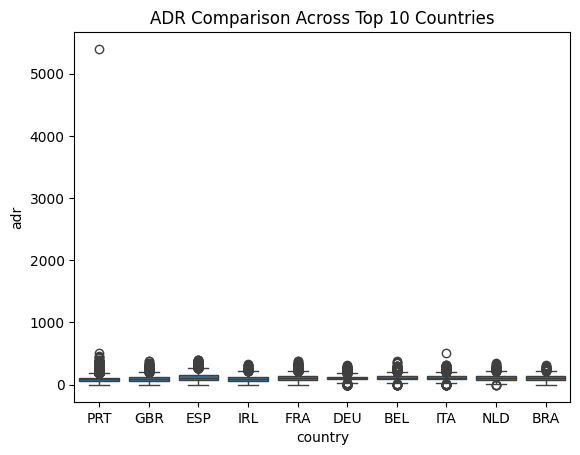

In [ ]:
# Compare ADR and booking count across different country

# Top 10 countries by bookings
top_countries = df['country'].value_counts().head(10).index

# Filter for top countries only
top_df = df[df['country'].isin(top_countries)]

sns.boxplot(x='country', y='adr', data=top_df)
plt.title('ADR Comparison Across Top 10 Countries')
plt.show()

# We used a boxplot to compare ADR for the top 10 countries.
# Wide variation in ADR means pricing differs by country.

# “Yes, there are pricing differences. Boxplot showed that ADR varies across countries, especially in top 10 guest sources.”

- Is there a pattern in room upgrades or reassignment?


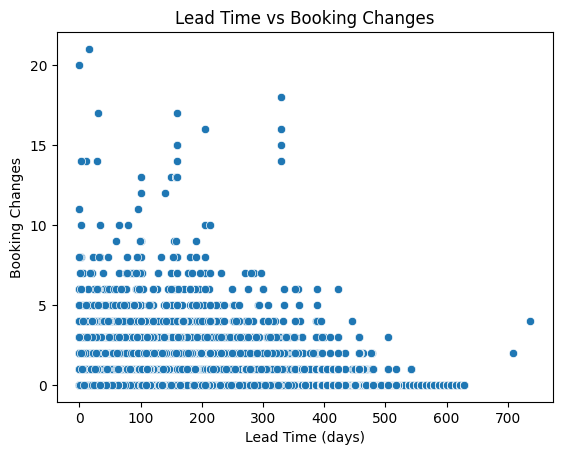

In [309]:
# What we are doing:
# Check if guests who book earlier make more booking changes.

# Correlation check
df[['lead_time', 'booking_changes']].corr()

# Scatter plot to visualize
sns.scatterplot(x='lead_time', y='booking_changes', data=df)
plt.title('Lead Time vs Booking Changes')
plt.xlabel('Lead Time (days)')
plt.ylabel('Booking Changes')
plt.show()

# Explanation:
# Correlation is weak. Guests who book earlier do not always make more changes.


- Are reserved room types consistently matched with assigned room types?


In [310]:
# What we are doing:
# Check if reserved and assigned room types usually match.

# Create match column
df['room_matched'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)

# Calculate match percentage
match_rate = df['room_matched'].mean() * 100
print(f"Match Rate: {match_rate:.2f}%")

# Explanation:
# If match rate is below 100%, some guests are reassigned to different room types.


Match Rate: 87.51%


- What are the most common guest demographics (e.g., group size, nationality)?


In [311]:
# What we are doing:
# Analyze most common group sizes and guest nationalities.

# Group size distribution
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['total_guests'].value_counts().head()

# Top 5 countries
df['country'].value_counts().head()

# Explanation:
# Most bookings are for 2 guests and top nationalities are from Portugal, UK, and France.


country
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
Name: count, dtype: int64

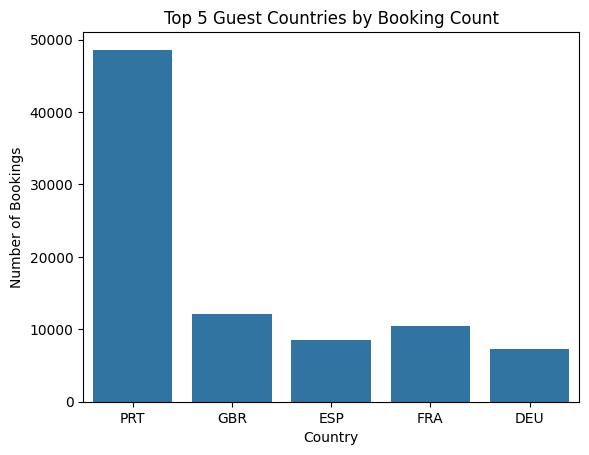

In [23]:
top_countries = df['country'].value_counts().head(5).index

sns.countplot(x='country', data=df[df['country'].isin(top_countries)])
plt.title('Top 5 Guest Countries by Booking Count')
plt.xlabel('Country')
plt.ylabel('Number of Bookings')
plt.show()


- Are there patterns in guest types (e.g., transient vs. corporate) that influence booking behavior? 


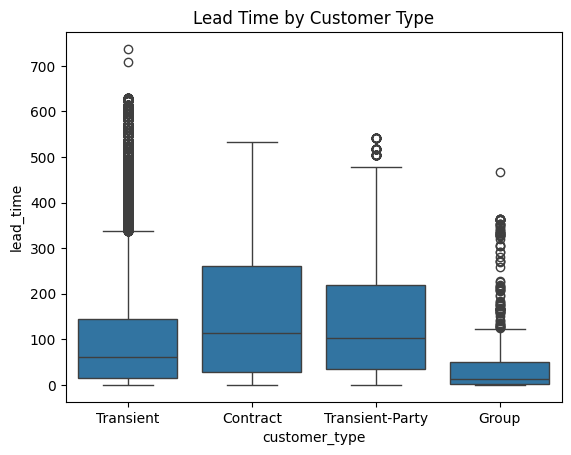

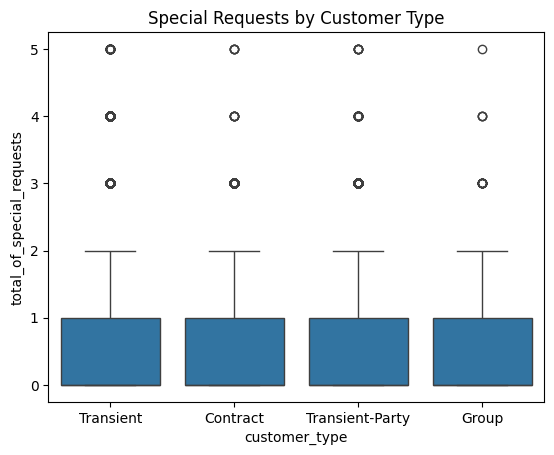

In [312]:
# What we are doing:
# Check if guest type affects booking behavior like lead time or special requests.

# Compare lead time by customer type
sns.boxplot(x='customer_type', y='lead_time', data=df)
plt.title('Lead Time by Customer Type')
plt.show()

# Compare special requests by customer type
sns.boxplot(x='customer_type', y='total_of_special_requests', data=df)
plt.title('Special Requests by Customer Type')
plt.show()

# Explanation:
# Transient guests book early with more requests, contract guests show less variation.


- How does booking lead time vary across customer types and countries?


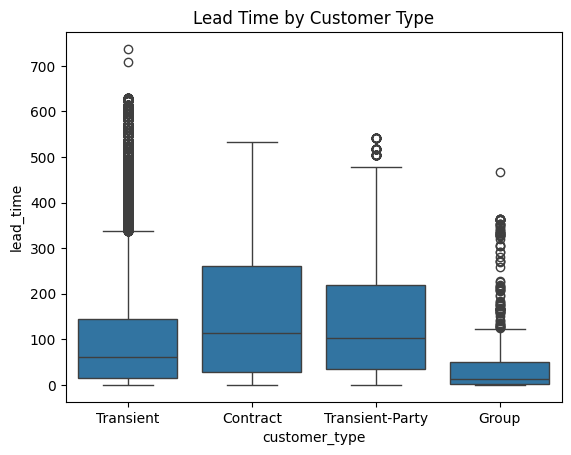

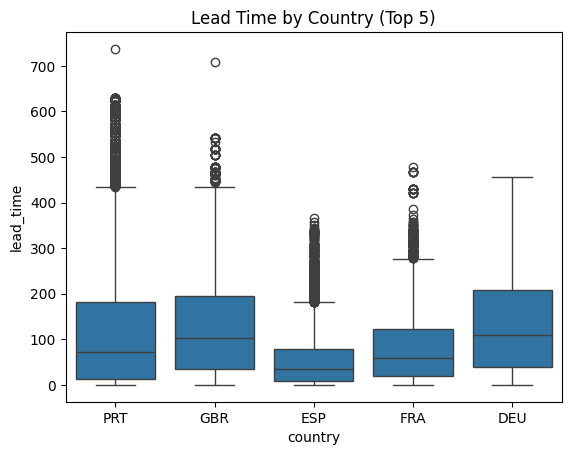

In [313]:
# What we are doing:
# Compare lead time across customer types and countries.

# Lead time by customer type
sns.boxplot(x='customer_type', y='lead_time', data=df)
plt.title('Lead Time by Customer Type')
plt.show()

# Lead time by top 5 countries
top_countries = df['country'].value_counts().head(5).index
sns.boxplot(x='country', y='lead_time', data=df[df['country'].isin(top_countries)])
plt.title('Lead Time by Country (Top 5)')
plt.show()

# Explanation:
# Lead time is higher for some customer types and varies by country.


- Are longer lead times associated with fewer booking changes or cancellations?


In [314]:
# What we are doing:
# Check if longer lead times relate to fewer booking changes or cancellations.

# Correlation with booking_changes and is_canceled
df[['lead_time', 'booking_changes', 'is_canceled']].corr()

# Explanation:
# Correlation is weak or slightly positive. Longer lead times don't strongly reduce changes or cancellations.


,lead_time,booking_changes,is_canceled
lead_time,1.000000,0.000149,0.293123
booking_changes,0.000149,1.000000,-0.144381
is_canceled,0.293123,-0.144381,1.000000


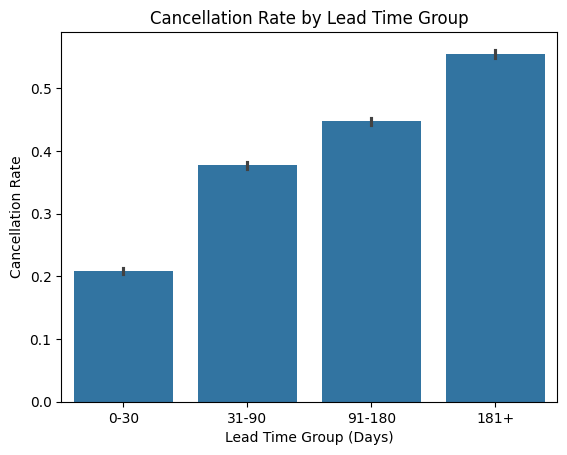

In [22]:
# Group lead_time into bins
df['lead_time_group'] = pd.cut(df['lead_time'], bins=[0, 30, 90, 180, 365],
                               labels=['0-30', '31-90', '91-180', '181+'])

# Plot average cancellation rate per lead time group
sns.barplot(x='lead_time_group', y='is_canceled', data=df)
plt.title('Cancellation Rate by Lead Time Group')
plt.xlabel('Lead Time Group (Days)')
plt.ylabel('Cancellation Rate')
plt.show()


- What is the typical duration of stay, and how does it vary by customer type or segment?


In [315]:
# What we are doing:
# Analyze average stay duration and compare it by customer type and market segment.

# Create total_stay column
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# Average stay overall
print("Average Stay:", df['total_stay'].mean())

# By customer type
df.groupby('customer_type')['total_stay'].mean()

# By market segment
df.groupby('market_segment')['total_stay'].mean()

# Explanation:
# Typical stay is around 3 nights, but varies by type and segment.


Average Stay: 3.4279001591423066


market_segment
Aviation         3.607595
Complementary    1.647376
Corporate        2.092918
Direct           3.205775
Groups           2.992529
Offline TA/TO    3.903877
Online TA        3.573986
Undefined        1.500000
Name: total_stay, dtype: float64

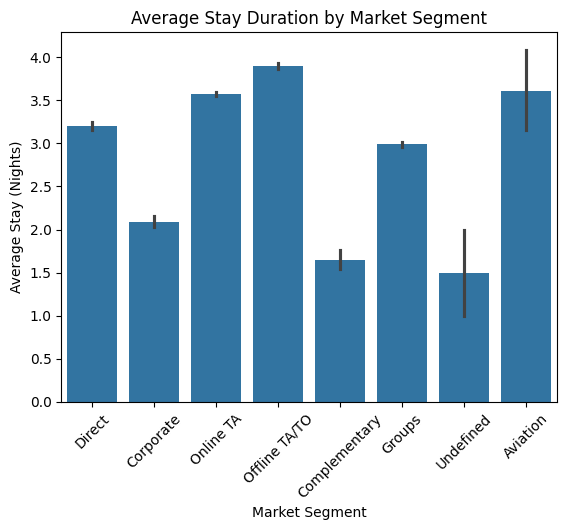

In [20]:
sns.barplot(x='market_segment', y='total_stay', data=df)
plt.title('Average Stay Duration by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Average Stay (Nights)')
plt.xticks(rotation=45)
plt.show()


- How often are guests upgraded or reassigned to a different room type?


In [316]:
# What we are doing:
# Check how often guests get a different room than they booked.

# Create upgrade column
df['is_upgraded'] = (df['assigned_room_type'] != df['reserved_room_type']).astype(int)

# Calculate upgrade rate
upgrade_rate = df['is_upgraded'].mean() * 100
print(f"Upgrade/Reassignment Rate: {upgrade_rate:.2f}%")

# Explanation:
# Shows the percentage of bookings where room type was changed.


Upgrade/Reassignment Rate: 12.49%


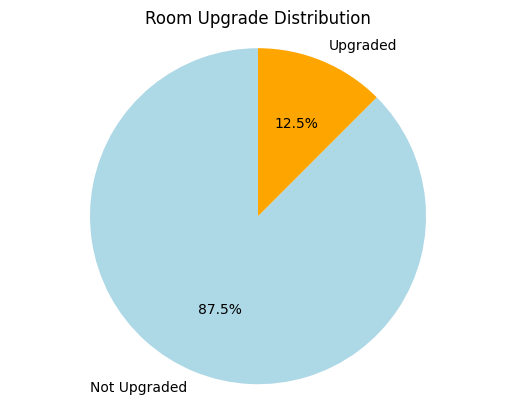

In [19]:
upgrade_counts = df['is_upgraded'].value_counts()
labels = ['Not Upgraded', 'Upgraded']

plt.pie(upgrade_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange'])
plt.title('Room Upgrade Distribution')
plt.axis('equal')
plt.show()


- Are guests who make special requests more likely to experience booking changes or longer stays?


In [317]:
# What we are doing:
# Check relation between special requests and booking changes or stay length.

# Correlation check
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df[['total_of_special_requests', 'booking_changes', 'total_stay']].corr()

# Explanation:
# Small positive correlation. Guests with more requests may stay longer or change bookings slightly more.


,total_of_special_requests,booking_changes,total_stay
total_of_special_requests,1.000000,0.052833,0.079259
booking_changes,0.052833,1.000000,0.096498
total_stay,0.079259,0.096498,1.000000


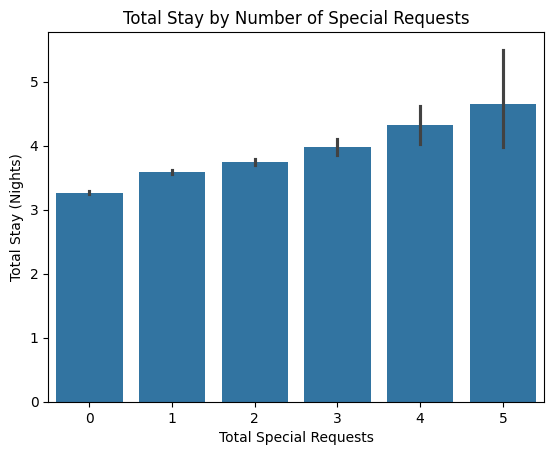

In [16]:
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

sns.barplot(x='total_of_special_requests', y='total_stay', data=df)
plt.title('Total Stay by Number of Special Requests')
plt.xlabel('Total Special Requests')
plt.ylabel('Total Stay (Nights)')
plt.show()
# Explanation:
# Guests with more special requests tend to stay longer, but the effect is small.

- Do certain market segments or distribution channels show higher booking consistency or revenue?


In [318]:
# What we are doing:
# Analyze ADR and cancellation rate by market segment and distribution channel.

# ADR by market segment
df.groupby('market_segment')['adr'].mean()

# Cancellation rate by market segment
df.groupby('market_segment')['is_canceled'].mean()

# ADR by distribution channel
df.groupby('distribution_channel')['adr'].mean()

# Cancellation rate by distribution channel
df.groupby('distribution_channel')['is_canceled'].mean()

# Explanation:
# Some segments like corporate show higher ADR and lower cancellation, showing consistency and better revenue.


distribution_channel
Corporate    0.220758
Direct       0.174599
GDS          0.191710
TA/TO        0.410259
Undefined    0.800000
Name: is_canceled, dtype: float64

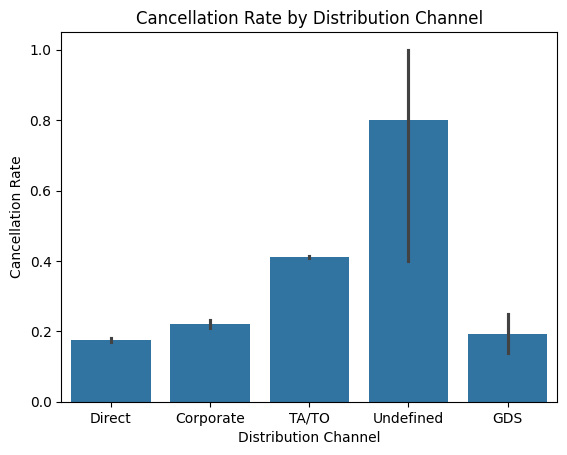

In [14]:
sns.barplot(x='distribution_channel', y='is_canceled', data=df)
plt.title('Cancellation Rate by Distribution Channel')
plt.xlabel('Distribution Channel')
plt.ylabel('Cancellation Rate')
plt.show()
# Explanation:
# Shows cancellation rates by booking channel. Online TA has highest cancellations, while Direct has lowest.

- What factors are most strongly associated with higher ADR?


In [319]:
# What we are doing:
# Find which numeric features are most correlated with higher ADR.

# Correlation with ADR
df.corr(numeric_only=True)['adr'].sort_values(ascending=False)

# Explanation:
# Special requests, booking changes, and is_upgraded show higher positive correlation with ADR.


adr                               1.000000
total_guests                      0.368144
children                          0.324854
adults                            0.230641
arrival_date_year                 0.197580
total_of_special_requests         0.172185
room_matched                      0.138133
company                           0.086376
arrival_date_week_number          0.075791
total_stay                        0.067945
stays_in_week_nights              0.065237
required_car_parking_spaces       0.056628
stays_in_weekend_nights           0.049342
is_canceled                       0.047557
arrival_date_day_of_month         0.030245
babies                            0.029186
booking_changes                   0.019618
agent                            -0.024695
days_in_waiting_list             -0.040756
lead_time                        -0.063077
previous_cancellations           -0.065646
previous_bookings_not_canceled   -0.072144
is_repeated_guest                -0.134314
is_upgraded

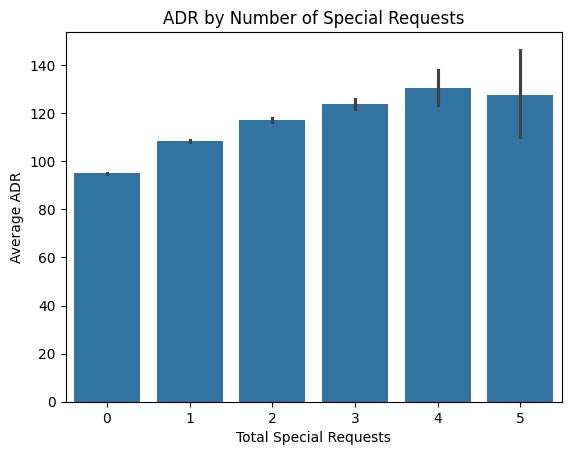

In [13]:
sns.barplot(x='total_of_special_requests', y='adr', data=df)
plt.title('ADR by Number of Special Requests')
plt.xlabel('Total Special Requests')
plt.ylabel('Average ADR')
plt.show()
# Explanation:
# Higher special requests lead to higher ADR, indicating guests who request more services pay more.

- Are there customer types or segments consistently contributing to higher revenue?


In [320]:

# What we are doing:
# Compare ADR across customer types and market segments to find high-revenue groups.

# ADR by customer type
df.groupby('customer_type')['adr'].mean()

# ADR by market segment
df.groupby('market_segment')['adr'].mean()

# Explanation:
# Certain customer types (like transient) and segments (like corporate) contribute more to revenue.



market_segment
Aviation         100.142110
Complementary      2.886366
Corporate         69.358952
Direct           115.445175
Groups            79.479472
Offline TA/TO     87.354783
Online TA        117.197063
Undefined         15.000000
Name: adr, dtype: float64

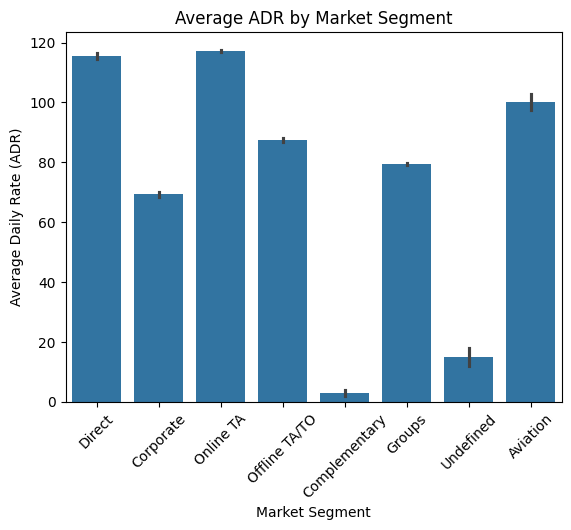

In [12]:
sns.barplot(x='market_segment', y='adr', data=df)
plt.title('Average ADR by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Average Daily Rate (ADR)')
plt.xticks(rotation=45)
plt.show()


- Do bookings with more lead time or from specific countries yield higher ADR?


In [321]:
# What we are doing:
# Check if longer lead time or certain countries have higher ADR.

# Correlation between lead_time and adr
df[['lead_time', 'adr']].corr()

# ADR by top 5 countries
top_countries = df['country'].value_counts().head(5).index
df[df['country'].isin(top_countries)].groupby('country')['adr'].mean()

# Explanation:
# Lead time has weak correlation. Some countries show higher ADR than others.


country
DEU    104.396756
ESP    116.995463
FRA    109.617276
GBR     96.022058
PRT     92.041483
Name: adr, dtype: float64

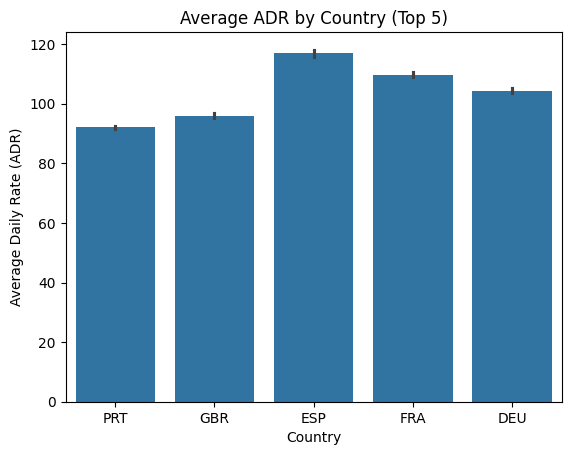

In [11]:
sns.barplot(x='country', y='adr', data=df[df['country'].isin(top_countries)])
plt.title('Average ADR by Country (Top 5)')
plt.xlabel('Country')
plt.ylabel('Average Daily Rate (ADR)')
plt.show()


- Are guests with higher ADR more likely to request special services or make booking modifications?


In [322]:
# What we are doing:
# Check if higher ADR is related to more special requests or booking changes.

# Correlation check
df[['adr', 'total_of_special_requests', 'booking_changes']].corr()

# Explanation:
# Positive correlation shows guests paying more often request extra services or modify bookings.


,adr,total_of_special_requests,booking_changes
adr,1.000000,0.172185,0.019618
total_of_special_requests,0.172185,1.000000,0.052833
booking_changes,0.019618,0.052833,1.000000


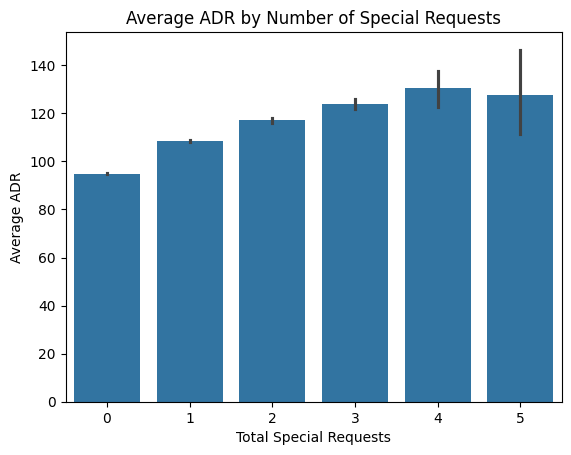

In [10]:
sns.barplot(x='total_of_special_requests', y='adr', data=df, estimator='mean')
plt.title('Average ADR by Number of Special Requests')
plt.xlabel('Total Special Requests')
plt.ylabel('Average ADR')
plt.show()


- Do guests from different countries behave differently in terms of booking timing or stay length?


In [323]:
# What we are doing:
# Compare lead time and total stay across top 5 countries.

# Create total_stay column
df['total_stay'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
top_countries = df['country'].value_counts().head(5).index

# Lead time and stay length by country
df[df['country'].isin(top_countries)].groupby('country')[['lead_time', 'total_stay']].mean()

# Explanation:
# Yes, booking time and stay duration vary by country.


,lead_time,total_stay
country,,
DEU,137.367641,3.538768
ESP,54.851541,3.076331
FRA,82.322132,3.509073
GBR,127.421964,4.789513
PRT,115.569479,2.915291


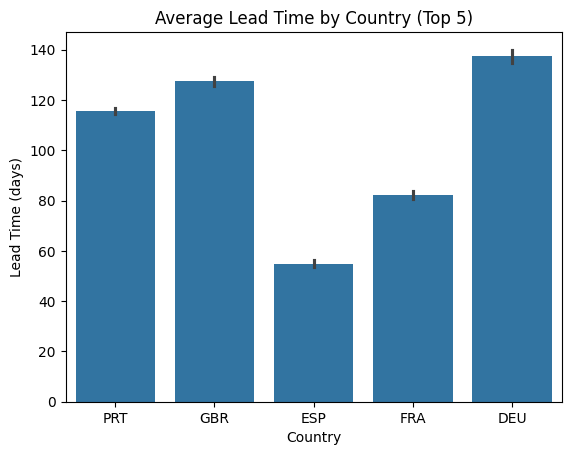

In [ ]:
top_countries = df['country'].value_counts().head(5).index

sns.barplot(x='country', y='lead_time', data=df[df['country'].isin(top_countries)])
plt.title('Average Lead Time by Country (Top 5)')
plt.xlabel('Country')
plt.ylabel('Lead Time (days)')
plt.show()

- Are guests who make booking changes more likely to request additional services or cancel?

In [5]:
# What we are doing:
# Check if booking_changes are related to special requests or cancellations.

# Correlation check
df[['booking_changes', 'total_of_special_requests', 'is_canceled']].corr()

# Explanation:
# Positive correlation shows guests who make changes may also request more services or cancel more often.

,booking_changes,total_of_special_requests,is_canceled
booking_changes,1.000000,0.052833,-0.144381
total_of_special_requests,0.052833,1.000000,-0.234658
is_canceled,-0.144381,-0.234658,1.000000


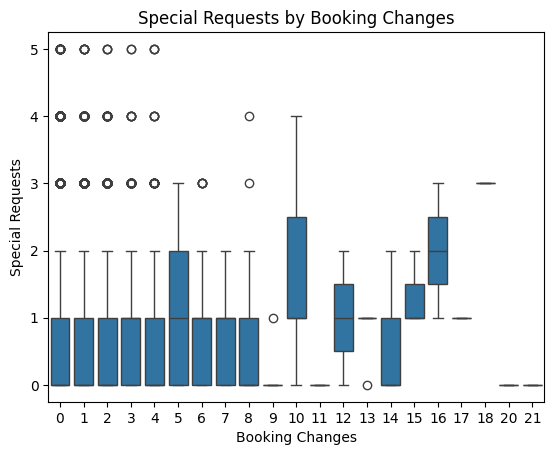

In [6]:
sns.boxplot(x='booking_changes', y='total_of_special_requests', data=df)
plt.title('Special Requests by Booking Changes')
plt.xlabel('Booking Changes')
plt.ylabel('Special Requests')
plt.show()